In [12]:
import sys
import json
sys.path.append("/home/rbalogun/intertwin/raster-to-stac")

import xarray as xr
import matplotlib.pyplot as plt
import rioxarray
import pystac_client
import odc.stac

from raster2stac import raster2stac as r2slib

In [2]:
# ensure netCDF data has the required CRS input
data_path = "/mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/cerra/2m_temperature/t2m_2001.nc"
ds = xr.open_dataset(data_path)
ds.rio.write_crs("epsg:4326", inplace=True)
ds.to_netcdf("/mnt/CEPH_PROJECTS/InterT win/hydrologic_data/cerra/2m_temperature/t2m_2001_w_crs.nc")
ds

In [4]:
r2s = r2slib.Raster2STAC(
    "/mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/cerra/2m_temperature/t2m_2001_w_crs.nc", # data
    "CERRA_2m_temperature_2001", # collection_id
    "https://stac.eurac.edu/collection", # collection_url
    output_folder="/home/rbalogun/intertwin/cerra/stac/",
    output_file='CERRA_2m_temperature_2001.json',
    description="The Copernicus European Regional ReAnalysis (CERRA) datasets provide spatially and \
        temporally consistent historical reconstructions of meteorological variables in the atmosphere \
        and at the surface. ",
    title="CERRA sub-daily regional reanalysis data for the European Alps on single levels",
    ignore_warns=False,
    keywords=['intertwin', 'temperature', 'cerra', 'climate'],
    links= [{
        "rel": "license",
        "href": "https://cds.climate.copernicus.eu/api/v2/terms/static/licence-to-use-copernicus-products.pdf",
        "title": "License to use Copernicus Products"
    }],
    providers=[
        {
            "url": "https://cds.climate.copernicus.eu/cdsapp#!/dataset/10.24381/cds.622a565a",
            "name": "Copernicus",
            "roles": [
                "producer",
                "licensor"
            ]
        },
        {
            "url": "http://www.eurac.edu",
            "name": "Eurac EO",
            "roles": [
            "host"
            ]
        }
    ],
    stac_version="1.0.0",
    verbose=True,
    s3_upload=True,
    version=None,
    output_format="csv",
    license="proprietary",
    write_json_items=True,
    sci_doi='https://doi.org/10.24381/cds.622a565a',
    sci_citation= "Schimanke S., Ridal M., Le Moigne P., Berggren L., Undén P., Randriamampianina R., Andrea U., \
        Bazile E., Bertelsen A., Brousseau P., Dahlgren P., Edvinsson L., El Said A., Glinton M., Hopsch S., \
        Isaksson L., Mladek R., Olsson E., Verrelle A., Wang Z.Q., (2021): CERRA sub-daily regional reanalysis \
        data for Europe on single levels from 1984 to present. Copernicus Climate Change Service (C3S) Climate \
        Data Store (CDS), DOI: 10.24381/cds.622a565a (Accessed on 15-02-2024)"
)

r2s.generate_stac()


Load a sample metadata with downstream package 

In [8]:
url = "/home/rbalogun/intertwin/cerra/stac/items-json/CERRA_2m_temperature_2001-20010101000000.json"

stac_api = pystac_client.stac_api_io.StacApiIO()
stac_dict = json.loads(stac_api.read_text(url))
items = stac_api.stac_object_from_dict(stac_dict)

ds_stac = odc.stac.load([items])
ds_stac

<xarray.Dataset>
Dimensions:      (latitude: 98, longitude: 163, time: 1)
Coordinates:
  * latitude     (latitude) float64 43.55 43.62 43.69 43.75 ... 49.93 50.0 50.06
  * longitude    (longitude) float64 5.084 5.151 5.218 ... 15.82 15.89 15.96
    spatial_ref  int32 4326
  * time         (time) datetime64[ns] 2001-01-01
Data variables:
    t2m          (time, latitude, longitude) float32 7.436 7.107 ... -5.814

Compare data CoGs data values

In [9]:
import rioxarray
ds_rio = rioxarray.open_rasterio("/home/rbalogun/intertwin/cerra/stac/20010101000000/t2m_20010101000000.tif")
ds_rio

<xarray.DataArray (band: 1, y: 98, x: 163)>
[15974 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 5.084 5.151 5.218 5.285 ... 15.76 15.82 15.89 15.96
  * y            (y) float64 43.55 43.62 43.69 43.75 ... 49.86 49.93 50.0 50.06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      t2m

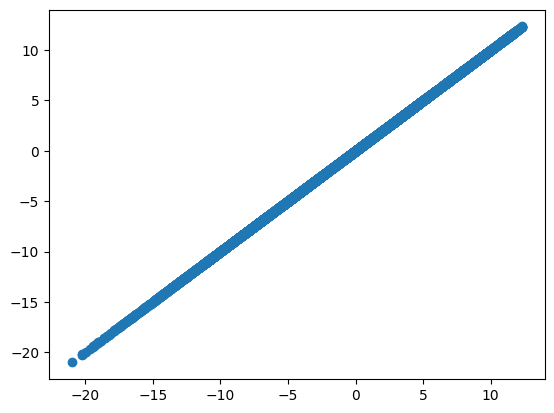

In [13]:
plt.scatter(ds_stac.t2m.values, ds_rio.sel(band=1).values)